## Nearest Neighbor item based Collaborative Filtering

![image.png](https://miro.medium.com/max/1400/1*aSq9viZGEYiWwL9uJ3Recw.png)

Source: https://towardsdatascience.com
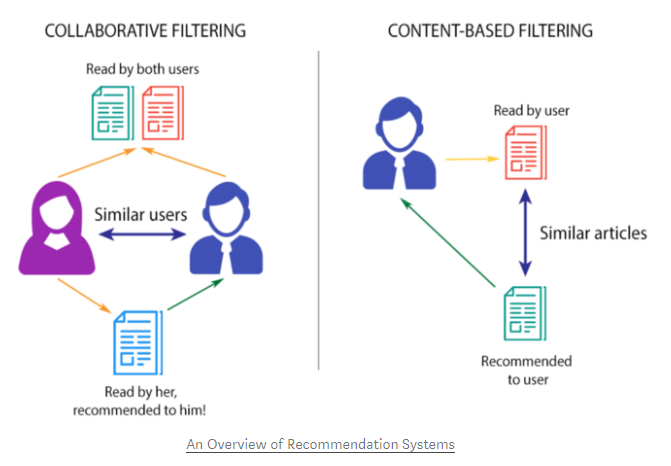

In [12]:
##Dataset url: https://grouplens.org/datasets/movielens/latest/

import pandas as pd
import numpy as np

In [13]:
r_cols = ['user_id','movie_id','rating']
movies_df = pd.read_csv('u.item.csv', names=['movieId','title'],sep='|',usecols=range(2))
m_cols = ['movie_id','title']
rating_df=pd.read_csv('u.data.csv', names=['userId', 'movieId', 'rating'],usecols=range(3))

In [14]:
movies_df.head()

movieId              title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)

In [15]:
rating_df.head()

userId  movieId  rating
0       0       50       5
1       0      172       5
2       0      133       1
3     196      242       3
4     186      302       3

In [22]:
df = pd.merge(rating_df,movies_df,on='movieId')
df.head()

userId  movieId  rating             title
0       0       50       5  Star Wars (1977)
1     290       50       5  Star Wars (1977)
2      79       50       4  Star Wars (1977)
3       2       50       5  Star Wars (1977)
4       8       50       5  Star Wars (1977)

In [34]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])
# combine_movie_rating.shape
movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()


title  totalRatingCount
0  'Til There Was You (1997)                 9
1               1-900 (1994)                 5
2      101 Dalmatians (1996)               109
3        12 Angry Men (1957)               125
4                 187 (1997)                41

In [42]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_with_totalRatingCount.head()

userId  movieId  rating             title  totalRatingCount
0       0       50       5  Star Wars (1977)               584
1     290       50       5  Star Wars (1977)               584
2      79       50       4  Star Wars (1977)               584
3       2       50       5  Star Wars (1977)               584
4       8       50       5  Star Wars (1977)               584

In [43]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   1664.000
mean      60.098
std       80.963
min        1.000
25%        7.000
50%       27.000
75%       80.250
max      584.000
Name: totalRatingCount, dtype: float64


In [44]:
popularity_threshold = 50
rating_popular_movie= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()

userId  movieId  rating             title  totalRatingCount
0       0       50       5  Star Wars (1977)               584
1     290       50       5  Star Wars (1977)               584
2      79       50       4  Star Wars (1977)               584
3       2       50       5  Star Wars (1977)               584
4       8       50       5  Star Wars (1977)               584

In [45]:
rating_popular_movie.shape

(84072, 5)

In [65]:
## First lets create a Pivot matrix

movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df.head()

userId                                0     1     2     3     4     5     6    \
title                                                                           
101 Dalmatians (1996)               0.000 2.000 0.000 0.000 0.000 2.000 0.000   
12 Angry Men (1957)                 0.000 5.000 0.000 0.000 0.000 0.000 4.000   
2 Days in the Valley (1996)         0.000 0.000 0.000 0.000 0.000 0.000 0.000   
20,000 Leagues Under the Sea (1954) 0.000 3.000 0.000 0.000 0.000 0.000 0.000   
2001: A Space Odyssey (1968)        0.000 4.000 0.000 0.000 0.000 4.000 5.000   

userId                                7     8     9    ...   934   935   936  \
title                                                  ...                     
101 Dalmatians (1996)               0.000 0.000 0.000  ... 2.000 0.000 0.000   
12 Angry Men (1957)                 4.000 0.000 0.000  ... 0.000 0.000 0.000   
2 Days in the Valley (1996)         0.000 0.000 0.000  ... 0.000 0.000 4.000   
20,000 Leagues Under the Sea (1954) 5.000 0.000 0.000  ... 0.000 0.000 0.000   
2001: A Space Odyssey (1968)        5.000 0.000 0.000  ... 4.000 0.000 0.000   

userId                                937   938   939   940   941   942   943  
title                                                                          
101 Dalmatians (1996)               2.000 4.000 0.000 0.000 0.000 0.000 0.000  
12 Angry Men (1957)                 0.000 0.000 0.000 0.000 0.000 0.000 0.000  
2 Days in the Valley (1996)         0.000 0.000 0.000 0.000 0.000 0.000 2.000  
20,000 Leagues Under the Sea (1954) 0.000 0.000 0.000 0.000 0.000 0.000 0.000  
2001: A Space Odyssey (1968)        0.000 0.000 0.000 0.000 0.000 3.000 0.000  

[5 rows x 944 columns]

In [66]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

# print(movie_features_df_matrix)
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [67]:
movie_features_df.shape

(605, 944)

In [87]:
# query_index = np.random.choice(movie_features_df.shape[0])
# print(query_index)
query_index = movie_features_df.index.get_loc('Star Wars (1977)')
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)


In [88]:
movie_features_df.head()

userId                                0     1     2     3     4     5     6    \
title                                                                           
101 Dalmatians (1996)               0.000 2.000 0.000 0.000 0.000 2.000 0.000   
12 Angry Men (1957)                 0.000 5.000 0.000 0.000 0.000 0.000 4.000   
2 Days in the Valley (1996)         0.000 0.000 0.000 0.000 0.000 0.000 0.000   
20,000 Leagues Under the Sea (1954) 0.000 3.000 0.000 0.000 0.000 0.000 0.000   
2001: A Space Odyssey (1968)        0.000 4.000 0.000 0.000 0.000 4.000 5.000   

userId                                7     8     9    ...   934   935   936  \
title                                                  ...                     
101 Dalmatians (1996)               0.000 0.000 0.000  ... 2.000 0.000 0.000   
12 Angry Men (1957)                 4.000 0.000 0.000  ... 0.000 0.000 0.000   
2 Days in the Valley (1996)         0.000 0.000 0.000  ... 0.000 0.000 4.000   
20,000 Leagues Under the Sea (1954) 5.000 0.000 0.000  ... 0.000 0.000 0.000   
2001: A Space Odyssey (1968)        5.000 0.000 0.000  ... 4.000 0.000 0.000   

userId                                937   938   939   940   941   942   943  
title                                                                          
101 Dalmatians (1996)               2.000 4.000 0.000 0.000 0.000 0.000 0.000  
12 Angry Men (1957)                 0.000 0.000 0.000 0.000 0.000 0.000 0.000  
2 Days in the Valley (1996)         0.000 0.000 0.000 0.000 0.000 0.000 2.000  
20,000 Leagues Under the Sea (1954) 0.000 0.000 0.000 0.000 0.000 0.000 0.000  
2001: A Space Odyssey (1968)        0.000 0.000 0.000 0.000 0.000 3.000 0.000  

[5 rows x 944 columns]

In [89]:
distances

array([[6.77236045e-15, 1.16481831e-01, 2.35942977e-01, 2.49550083e-01,
        2.66223228e-01, 3.03423123e-01]])

In [90]:
indices

array([[524, 451, 434, 181, 562, 234]])

In [91]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Star Wars (1977):

1: Return of the Jedi (1983), with distance of 0.11648183086402542:
2: Raiders of the Lost Ark (1981), with distance of 0.2359429772070084:
3: Empire Strikes Back, The (1980), with distance of 0.24955008270687218:
4: Toy Story (1995), with distance of 0.26622322826178724:
5: Godfather, The (1972), with distance of 0.3034231233589749:


## Cosine Similarity

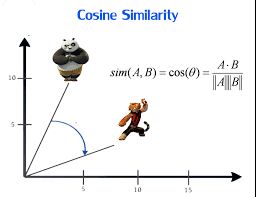
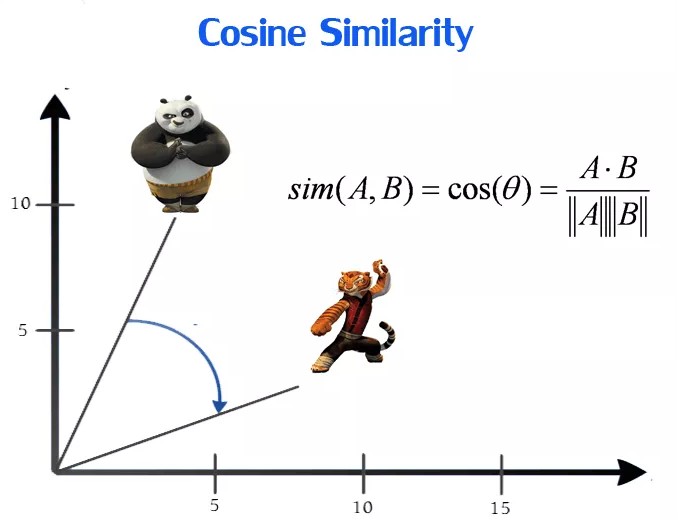

In [100]:
my_ratings = movie_features_df[0]
my_ratings = my_ratings.loc[my_ratings!=0]
my_ratings

title
Empire Strikes Back, The (1980)   5.000
Gone with the Wind (1939)         1.000
Star Wars (1977)                  5.000
Name: 0, dtype: float64

In [119]:
simCandidates = pd.Series()
for i in range(0,len(my_ratings.index)):
    print("Adding sims for ",my_ratings.index[i],"...")
    query_index = movie_features_df.index.get_loc(my_ratings.index[i])
#     print(query_index)
    
    distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
    distances = (1/(1+distances)) * my_ratings[i] 
#     print(distances)
    
    sims = pd.Series(distances.flatten(),
              name="ratings", index=movie_features_df.index[indices.flatten()])
#     sims = distances.map(lambda x: (1/x)*myRatings[i])
    print(sims)
    simCandidates = simCandidates.append(sims)

print('\nsorting..\n')
simCandidates.sort_values(inplace=True,ascending=False)
print(simCandidates.head(20))

Adding sims for  Empire Strikes Back, The (1980) ...
title
Empire Strikes Back, The (1980)             5.000
Raiders of the Lost Ark (1981)              4.247
Indiana Jones and the Last Crusade (1989)   4.090
Back to the Future (1985)                   4.011
Star Wars (1977)                            4.001
Terminator, The (1984)                      3.976
Name: ratings, dtype: float64
Adding sims for  Gone with the Wind (1939) ...
title
Gone with the Wind (1939)      1.000
Wizard of Oz, The (1939)       0.746
Sound of Music, The (1965)     0.704
Casablanca (1942)              0.704
It's a Wonderful Life (1946)   0.702
Back to the Future (1985)      0.693
Name: ratings, dtype: float64
Adding sims for  Star Wars (1977) ...
title
Star Wars (1977)                  5.000
Return of the Jedi (1983)         4.478
Raiders of the Lost Ark (1981)    4.045
Empire Strikes Back, The (1980)   4.001
Toy Story (1995)                  3.949
Godfather, The (1972)             3.836
Name: ratings, dtype: 

In [120]:
simCandidates = simCandidates.groupby(simCandidates.index).sum()
simCandidates.sort_values(inplace=True,ascending=False)
simCandidates.head(10)

Empire Strikes Back, The (1980)             9.001
Star Wars (1977)                            9.001
Raiders of the Lost Ark (1981)              8.293
Back to the Future (1985)                   4.704
Return of the Jedi (1983)                   4.478
Indiana Jones and the Last Crusade (1989)   4.090
Terminator, The (1984)                      3.976
Toy Story (1995)                            3.949
Godfather, The (1972)                       3.836
Gone with the Wind (1939)                   1.000
dtype: float64

In [123]:
filteredSims = simCandidates.drop(my_ratings.index)
filteredSims.head(10)

Raiders of the Lost Ark (1981)              8.293
Back to the Future (1985)                   4.704
Return of the Jedi (1983)                   4.478
Indiana Jones and the Last Crusade (1989)   4.090
Terminator, The (1984)                      3.976
Toy Story (1995)                            3.949
Godfather, The (1972)                       3.836
Wizard of Oz, The (1939)                    0.746
Sound of Music, The (1965)                  0.704
Casablanca (1942)                           0.704
dtype: float64

This is the final Recommendation of movies of similar that i was like earlier such as `Empire Strikes Back, The (1980)`, `Gone with the Wind (1939)`, `Star Wars (1977)`     